In [1]:
import torch
import pytorch_lightning as pl
import numpy as np
from omegaconf import OmegaConf
from torchsummary import summary

from modules.autoencoders import HamiltonianAutoencoder

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

cfg = OmegaConf.load('./config.yaml')

hvae = HamiltonianAutoencoder(**cfg.autoencoder).to(device)

loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth


In [2]:
x = torch.randn(4, 1, 128, 128).to(device)
pos = torch.randint(0, 64, size=(4,)).to(device, dtype=torch.long)

recon_x, z, z0, rho, eps0, gamma, mu, log_var = hvae(x, pos)

In [11]:
data = np.load('./data/brats_preprocessed.npy')

In [12]:
# norm between 0 and 1
data = (data - data.min()) / (data.max() - data.min())

In [14]:
data.max()

1.0

In [2]:
from modules.preprocessing import BRATSDataModule


datamodule = BRATSDataModule(**cfg.data)
datamodule.prepare_data()
datamodule.setup()
loader = datamodule.train_dataloader()

Dataset already exists at ./data/brats_preprocessed.npy
Loading dataset from npy file...
Train shape: torch.Size([10880, 2, 128, 128])
Test shape: torch.Size([1920, 2, 128, 128])
Train slice positions shape: torch.Size([10880])
Test slice positions shape: torch.Size([1920])
Min: 0.0, Max: 1.0


In [10]:
g = hvae.sample_img(n_samples=1)

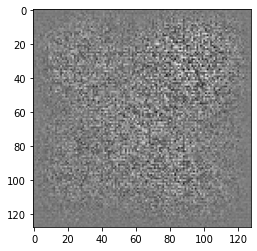

In [16]:
import matplotlib.pyplot as plt

plt.imshow((g[0, 0, ...].detach().cpu().numpy() * 255).astype(np.uint8), cmap='gray')